In [1]:
import sys
sys.path.append('..')

In [3]:
from models.networks.transformer import DVT
import yaml

cfg = """
input_features: 5
hidden: 32  # number of hidden features per layer
nb_layer: 3  # number of hidden layers  
nb_heads: 4  # number of heads
dropout: 0.1
steps: 2
hidden_activation: GELU
output_activation: GELU
variables: [Track.PT, Track.Eta, Track.Phi, Track.D0, Track.DZ]
use_checkpointing: False
concat_output: False
"""

cfg = yaml.load(cfg, Loader=yaml.SafeLoader)
dvt = DVT(cfg)

In [4]:
from models.utils import H5DVDataset
from torch.utils.data import DataLoader

base = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/"
qcd = base + "QCD_multijet_events_200k.h5"
llp = [base + "500GeV_n3_events_100k_1mm.h5", base + "100GeV_n3_events_100k_1mm.h5"]

ds = H5DVDataset(llp, qcd, read_in_memory=True)
dl = DataLoader(ds, shuffle=True, batch_size=256, pin_memory=True)
from torch.utils.data import Dataset, Sampler, DataLoader, random_split

# import random_split

train,test = random_split(ds, [0.8, 0.2])

In [5]:
len(train), len(test)

(312800, 78200)

In [4]:
import torch
from torch.utils.data import random_split
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def test_classifier(classifier, dset):
    classifier.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for batch in dset:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.long().to(device)
            labels = F.one_hot(labels.ravel(), num_classes=2).float()

            output = classifier(inputs, masks)
            _, predicted = torch.max(torch.sigmoid(output.data), 1)

            total += labels.size(0)
            accuracy += (predicted == labels[:, 1]).sum().item()
    return accuracy / total * 100


def train_classifier(
    dataset,
    num_high_pt=80,
    batch_size=512,
    epochs=100,
    notify_every=10,
    lr=0.001,
    tqdm=tqdm,
    reduce_lr=False,
):
    if tqdm is False:
        tqdm = lambda x, **kwargs: x

    classifier = DVT(cfg).to(device)

    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    if reduce_lr:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, "min", patience=10, verbose=True
        )

    val_split = 0.1
    train, val = random_split(dataset, [1 - val_split, val_split])
    dataloader = {
        "train": DataLoader(
            train,
            pin_memory=True,
            shuffle=True,
            batch_size=batch_size,
            drop_last=True,
            num_workers=6,
        ),
        "val": DataLoader(
            val,
            pin_memory=True,
            shuffle=True,
            batch_size=batch_size,
            drop_last=True,
            num_workers=2,
        ),
    }

    max_acc = 0.0
    accuracies = []
    losses = []
    for epoch in tqdm(range(epochs), total=epochs, leave=False):
        running_loss = []
        for i, batch in enumerate(tqdm(dataloader["train"])):
            optimizer.zero_grad()
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            # masks = (inputs.abs().sum(axis=2)!=0).unsqueeze(1)
            labels = labels.long().to(device)

            output = classifier(inputs, masks)
            loss = criterion(output, F.one_hot(labels.ravel(), num_classes=2).float())
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            losses.append(loss.item())

        accuracy = test_classifier(classifier, dataloader["val"])
        accuracies.append(accuracy)

        if reduce_lr:
            scheduler.step(losses[-1])

        if accuracy > max_acc:
            max_acc = accuracy
        if notify_every > 0 and (epoch + 1) % notify_every == 0:
            print(
                f"[{epoch+1:>3}] max acc: {max_acc:.1f}%, test acc: {accuracy:.1f}%, loss: {np.mean(running_loss):.3f}"
            )
    return classifier, accuracies, losses

In [ ]:
dataset = H5DVDataset(llp, qcd, num=-1, read_in_memory=True, num_high_pt=80)

In [13]:
clf, accuracies, losses = train_classifier(
    dataset,
    lr=0.001,
    batch_size=1024,
    epochs=50,
    notify_every=1,
    num_high_pt=80,
)

torch.save(clf.state_dict(), "dvt_80track_50epoch.pt")

  2%|▏         | 1/50 [00:06<05:20,  6.54s/it]

[  1] max acc: 90.5%, test acc: 90.5%, loss: 0.304


  4%|▍         | 2/50 [00:12<05:09,  6.44s/it]

[  2] max acc: 91.7%, test acc: 91.7%, loss: 0.216


  6%|▌         | 3/50 [00:19<05:00,  6.39s/it]

[  3] max acc: 91.9%, test acc: 91.9%, loss: 0.201


  8%|▊         | 4/50 [00:25<04:52,  6.35s/it]

[  4] max acc: 92.0%, test acc: 92.0%, loss: 0.192


 10%|█         | 5/50 [00:31<04:44,  6.32s/it]

[  5] max acc: 93.1%, test acc: 93.1%, loss: 0.183


 12%|█▏        | 6/50 [00:38<04:36,  6.29s/it]

[  6] max acc: 95.1%, test acc: 95.1%, loss: 0.168


 14%|█▍        | 7/50 [00:44<04:29,  6.26s/it]

[  7] max acc: 98.4%, test acc: 98.4%, loss: 0.082


 16%|█▌        | 8/50 [00:50<04:23,  6.28s/it]

[  8] max acc: 99.1%, test acc: 99.1%, loss: 0.035


 18%|█▊        | 9/50 [00:56<04:15,  6.24s/it]

[  9] max acc: 99.1%, test acc: 99.0%, loss: 0.027


 20%|██        | 10/50 [01:02<04:08,  6.21s/it]

[ 10] max acc: 99.2%, test acc: 99.2%, loss: 0.028


 22%|██▏       | 11/50 [01:08<04:01,  6.19s/it]

[ 11] max acc: 99.3%, test acc: 99.3%, loss: 0.020


 24%|██▍       | 12/50 [01:15<03:57,  6.25s/it]

[ 12] max acc: 99.4%, test acc: 99.4%, loss: 0.017


 26%|██▌       | 13/50 [01:21<03:51,  6.25s/it]

[ 13] max acc: 99.5%, test acc: 99.5%, loss: 0.016


 28%|██▊       | 14/50 [01:27<03:44,  6.24s/it]

[ 14] max acc: 99.5%, test acc: 99.5%, loss: 0.015


 30%|███       | 15/50 [01:34<03:39,  6.27s/it]

[ 15] max acc: 99.5%, test acc: 99.5%, loss: 0.015


 32%|███▏      | 16/50 [01:40<03:32,  6.25s/it]

[ 16] max acc: 99.6%, test acc: 99.6%, loss: 0.015


 34%|███▍      | 17/50 [01:46<03:25,  6.21s/it]

[ 17] max acc: 99.6%, test acc: 99.5%, loss: 0.013


 36%|███▌      | 18/50 [01:52<03:18,  6.20s/it]

[ 18] max acc: 99.6%, test acc: 99.6%, loss: 0.012


 38%|███▊      | 19/50 [01:58<03:12,  6.21s/it]

[ 19] max acc: 99.6%, test acc: 99.4%, loss: 0.012


 40%|████      | 20/50 [02:05<03:05,  6.19s/it]

[ 20] max acc: 99.6%, test acc: 99.6%, loss: 0.012


 42%|████▏     | 21/50 [02:11<03:00,  6.22s/it]

[ 21] max acc: 99.6%, test acc: 99.5%, loss: 0.011


 44%|████▍     | 22/50 [02:17<02:54,  6.23s/it]

[ 22] max acc: 99.6%, test acc: 99.6%, loss: 0.011


 46%|████▌     | 23/50 [02:23<02:48,  6.25s/it]

[ 23] max acc: 99.6%, test acc: 99.5%, loss: 0.010


 48%|████▊     | 24/50 [02:30<02:44,  6.32s/it]

[ 24] max acc: 99.6%, test acc: 99.6%, loss: 0.010


 50%|█████     | 25/50 [02:36<02:37,  6.32s/it]

[ 25] max acc: 99.6%, test acc: 99.6%, loss: 0.010


 52%|█████▏    | 26/50 [02:42<02:30,  6.28s/it]

[ 26] max acc: 99.6%, test acc: 99.6%, loss: 0.015


 54%|█████▍    | 27/50 [02:49<02:23,  6.25s/it]

[ 27] max acc: 99.6%, test acc: 99.6%, loss: 0.009


 56%|█████▌    | 28/50 [02:55<02:17,  6.23s/it]

[ 28] max acc: 99.7%, test acc: 99.7%, loss: 0.009


 58%|█████▊    | 29/50 [03:01<02:10,  6.23s/it]

[ 29] max acc: 99.7%, test acc: 99.7%, loss: 0.009


 60%|██████    | 30/50 [03:07<02:04,  6.23s/it]

[ 30] max acc: 99.7%, test acc: 99.7%, loss: 0.008


 62%|██████▏   | 31/50 [03:14<01:59,  6.27s/it]

[ 31] max acc: 99.7%, test acc: 99.7%, loss: 0.008


 64%|██████▍   | 32/50 [03:20<01:52,  6.25s/it]

[ 32] max acc: 99.7%, test acc: 99.7%, loss: 0.008


 66%|██████▌   | 33/50 [03:26<01:46,  6.26s/it]

[ 33] max acc: 99.7%, test acc: 99.7%, loss: 0.009


 68%|██████▊   | 34/50 [03:32<01:39,  6.24s/it]

[ 34] max acc: 99.7%, test acc: 99.7%, loss: 0.009


 70%|███████   | 35/50 [03:38<01:33,  6.23s/it]

[ 35] max acc: 99.7%, test acc: 99.7%, loss: 0.008


 72%|███████▏  | 36/50 [03:45<01:27,  6.25s/it]

[ 36] max acc: 99.7%, test acc: 99.7%, loss: 0.009


 74%|███████▍  | 37/50 [03:51<01:21,  6.25s/it]

[ 37] max acc: 99.7%, test acc: 99.7%, loss: 0.007


 76%|███████▌  | 38/50 [03:57<01:15,  6.26s/it]

[ 38] max acc: 99.8%, test acc: 99.8%, loss: 0.009


 78%|███████▊  | 39/50 [04:04<01:08,  6.24s/it]

[ 39] max acc: 99.8%, test acc: 99.7%, loss: 0.008


 80%|████████  | 40/50 [04:10<01:02,  6.26s/it]

[ 40] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 82%|████████▏ | 41/50 [04:16<00:56,  6.27s/it]

[ 41] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 84%|████████▍ | 42/50 [04:22<00:50,  6.27s/it]

[ 42] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 86%|████████▌ | 43/50 [04:29<00:44,  6.29s/it]

[ 43] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 88%|████████▊ | 44/50 [04:35<00:37,  6.25s/it]

[ 44] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 90%|█████████ | 45/50 [04:41<00:31,  6.26s/it]

[ 45] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 92%|█████████▏| 46/50 [04:47<00:25,  6.25s/it]

[ 46] max acc: 99.8%, test acc: 99.7%, loss: 0.007


 94%|█████████▍| 47/50 [04:54<00:18,  6.23s/it]

[ 47] max acc: 99.8%, test acc: 99.7%, loss: 0.006


 96%|█████████▌| 48/50 [05:00<00:12,  6.22s/it]

[ 48] max acc: 99.8%, test acc: 99.7%, loss: 0.009


 98%|█████████▊| 49/50 [05:06<00:06,  6.20s/it]

[ 49] max acc: 99.8%, test acc: 99.7%, loss: 0.007


100%|██████████| 343/343 [00:05<00:00, 59.51it/s]
                                               

[ 50] max acc: 99.8%, test acc: 99.7%, loss: 0.007


In [17]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1, len(accuracies) + 1)], accuracies)
plt.ylabel("Test accuracy [%]", color="tab:blue")
plt.xlabel("Epoch")
plt.twinx()
plt.plot(np.arange(len(losses)) / 343, losses, color="orange")
plt.ylabel("BCE Loss", color="tab:orange")

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="tab:blue", lw=4, label="Test accuracy [%]"),
    Line2D([0], [0], color="orange", lw=4, label="BCE loss"),
]
plt.legend(handles=legend_elements, loc="upper left", frameon=False)
plt.yscale("log")

plt.show()

In [5]:
def get_output(classifier, inputs, masks, labels, permute=False):
    classifier.eval()

    with torch.no_grad():
        bath_size = 1000
        i = 0
        output = []
        while i < len(inputs):
            inputs_batch = inputs[i : i + bath_size].to(device)
            masks_batch = masks[i : i + bath_size].to(device)
            labels_batch = labels[i : i + bath_size].long().to(device)
            
            if permute:
                inputs_batch = inputs_batch.permute(0, 2, 1)
                masks_batch = masks_batch.permute(0, 2, 1)[:,[0],:]
            
            labels_batch = F.one_hot(labels_batch.ravel(), num_classes=2)

            output_batch = classifier(inputs_batch, masks_batch)
            output_batch = torch.sigmoid(output_batch)
            output.append(output_batch)
            i += bath_size
            
        output = torch.cat(output, axis=0)
        return output

In [9]:
inputs = ds.inputs
masks = ds.masks
labels = ds.labels

output = get_output(clf, inputs, masks, labels)

NameError: name 'clf' is not defined

In [16]:
import matplotlib.pyplot as plt

def plot_sic(y_true, y_scores, label="SIC curve"):
    # Sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # Get the distinct values
    distinct_value_indices = np.where(np.diff(y_scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # True Positive Rates, False Positive Rates
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps

    # If no true positives, fix the TPRs and FPRs
    if tps.size == 0 or tps[-1] == 0:
        tpr = np.zeros_like(fps)
        fpr = np.zeros_like(fps)
    else:
        tpr = tps / tps[-1]
        fpr = fps / fps[-1]

    # get TPR/FPR at 50% cut
    idx = np.argmin(np.abs(y_scores - 0.5))
    tpr_at_50 = tpr[idx]
    fpr_at_50 = fpr[idx]

    # plt.scatter(
    #     tpr_at_50,
    #     tpr_at_50 / np.sqrt(fpr_at_50),
    #     label="50% cut: $\\epsilon_S={:.2f}, \\epsilon_B={:.2f}$".format(
    #         tpr_at_50, fpr_at_50
    #     ),
    # )
    plt.plot(tpr, tpr / np.sqrt(fpr), lw=2, label=label)
    plt.xlabel("$\\epsilon_S$", fontsize=20)
    plt.ylabel("$\\epsilon_S/\\sqrt{\\epsilon_B}$", fontsize=20)
    # plt.legend(loc="upper right", frameon=False)
    # plt.show()


# Example usage
# y_true: actual labels (1 for positive class, 0 for negative class)
# y_scores: predicted probabilities for the positive class
y_pred = output[:, 1].cpu().numpy()
y_truth = labels.cpu().numpy().ravel()

plot_sic(y_truth, y_pred)

NameError: name 'output' is not defined

In [17]:
def plot_classifier_sics(dataset, classifiers, labels, permute):
    plt.figure()
    for i,clf in enumerate(classifiers):
        output = get_output(clf, dataset.inputs, dataset.masks, dataset.labels, permute=permute[i])
        y_pred = output[:, 1].cpu().numpy()
        y_truth = dataset.labels.cpu().numpy().ravel()
        plot_sic(
            y_truth,
            y_pred,
            label=labels[i],
        )
    plt.legend()
    plt.show()

/tmp/ipykernel_2815871/1293820144.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, tpr / np.sqrt(fpr), lw=2, label=label)


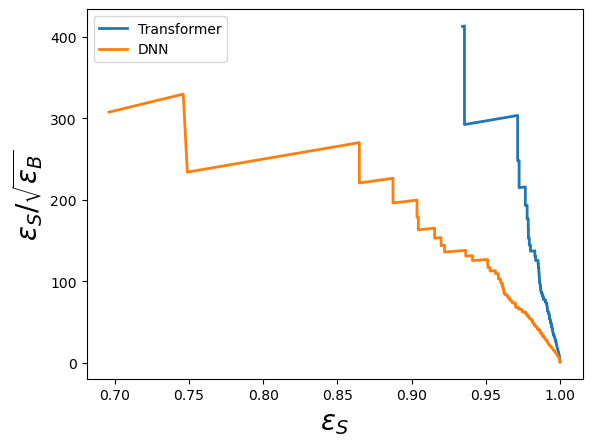

In [19]:
clf_DVT = DVT(cfg).to(device)
clf_DVT.load_state_dict(torch.load("dvt_80track_50epoch.pt"))

from models.networks.dnn import DNNClassifier

clf_DNN = DNNClassifier(
    in_features=5,
    hidden_layers=3,
    hidden_features=32,
    out_features=2,
    permute_input=True,
    normalize_input=True,
    final_reduction="mean",
).to(device)
clf_DNN.load_state_dict(torch.load("dnn_80track_50epoch.pt"))

plot_classifier_sics(ds, [clf_DVT, clf_DNN], ["Transformer", "DNN"], [0, 1])